In [ ]:
import numpy as np
import csv
import datetime
import time

In [ ]:
def addElement(array, index, ele):
    if array and index < len(array):
        array[index] += ele
        return array
    newArray = [0] * (index + 1)
    if array:
        newArray[:len(array)] = array
    newArray[index] = ele
    return newArray

In [ ]:
trafficRecordsById = {}
startTime = 1433142000

with open("new.csv") as f:
    trafficRecords = csv.reader(f, delimiter=',')
    count = 0
    for trafficRecord in trafficRecords:
        if count % 100000 == 0:
            print (count / 24015249 * 100, "%")
#         if count == 30000:
#             break
        recordTime = trafficRecord[1]
        checkPointId = trafficRecord[2]
        lane = int(trafficRecord[3])
        traffic = int(trafficRecord[4])

        relativeTime = time.mktime(datetime.datetime.strptime(recordTime, "%Y-%m-%d %H:%M:%S").timetuple()) - startTime
#         print (relativeTime)
        intervalId = relativeTime // 300
#         print (intervalId)
        
        trafficRecordsForId = trafficRecordsById.get(checkPointId)
        if not trafficRecordsForId:
            trafficByLane = addElement(None, lane, traffic)
            trafficRecordsById[checkPointId] = [(intervalId, trafficByLane)]
        else:
            prevIntervalId = trafficRecordsForId[-1][0]
            prevTrafficByLane = trafficRecordsForId[-1][1]
            if (intervalId == prevIntervalId):
                trafficRecordsForId[-1] = (intervalId, addElement(prevTrafficByLane, lane, traffic))
            else:
                trafficRecordsForId.append((intervalId, addElement(None, lane, traffic)))
        count += 1
                

import pickle

pickle.dump(trafficRecordsById, open("trafficRecordsById.p", "wb"))
    

In [1]:
import pickle
trafficRecordsByIdLoaded = pickle.load(open("trafficRecordsById.p", "rb"))

In [2]:
def checkMissingSpots(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    prevIndex = -1
    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        if intervalId != prevIndex + 1:
            print (prevIndex, intervalId)
        prevIndex = intervalId

running
True
plot


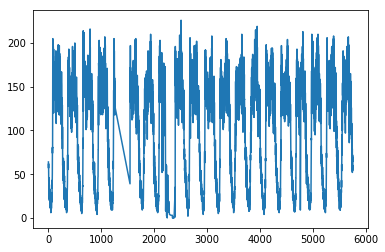

[(0.0, [13, 3, 14, 34]),
 (1.0, [17, 9, 10, 21]),
 (2.0, [23, 6, 8, 20]),
 (3.0, [16, 11, 12, 23]),
 (4.0, [12, 3, 9, 20]),
 (5.0, [13, 8, 6, 25]),
 (6.0, [12, 6, 9, 16]),
 (7.0, [7, 8, 5, 18]),
 (8.0, [8, 3, 8, 26]),
 (9.0, [6, 6, 4, 15]),
 (10.0, [15, 2, 7, 11]),
 (11.0, [9, 5, 5, 11]),
 (12.0, [15, 2, 5, 13]),
 (13.0, [11, 4, 10, 21]),
 (14.0, [11, 4, 4, 7]),
 (15.0, [7, 2, 3, 15]),
 (16.0, [7, 5, 2, 8]),
 (17.0, [10, 5, 0, 7]),
 (18.0, [5, 1, 9, 23]),
 (19.0, [4, 4, 2, 10]),
 (20.0, [10, 7, 2, 11]),
 (21.0, [4, 3, 3, 12]),
 (22.0, [4, 4, 3, 13]),
 (23.0, [7, 2, 4, 18]),
 (24.0, [5, 1, 3, 11]),
 (25.0, [10, 3, 5, 15]),
 (26.0, [6, 7, 5, 11]),
 (27.0, [9, 2, 3, 8]),
 (28.0, [5, 4, 2, 10]),
 (29.0, [6, 1, 3, 7]),
 (30.0, [7, 3, 0, 10]),
 (31.0, [5, 2, 1, 12]),
 (32.0, [6, 4, 1, 8]),
 (33.0, [4, 1, 2, 9]),
 (34.0, [7, 1, 2, 10]),
 (35.0, [3, 0, 1, 8]),
 (36.0, [8, 5, 0, 6]),
 (37.0, [4, 1, 1, 5]),
 (38.0, [6, 2, 4, 7]),
 (39.0, [5, 2, 0, 5]),
 (40.0, [5, 1, 2, 6]),
 (41.0, [5, 4, 1, 9]

In [4]:
import matplotlib.pyplot as plt
import bisect
def plotTrafficDistribution(checkPointId, timeRange=(None, None), plot=True):
    print ("running")
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    if trafficRecordsForId is None:
        print ("traffic records for id is None")
        return
    keys = [ele[0] for ele in trafficRecordsForId]
    
    startIntervalId = timeRange[0]
    endIntervalId = timeRange[1]

    startIndex = 0
    endIndex = len(trafficRecordsForId)
    
    if startIntervalId is not None:
        startIndex = bisect.bisect_left(keys, startIntervalId)
    
    if endIntervalId is not None:
        endIndex = bisect.bisect_right(keys, endIntervalId)
        
    print (plot)
    if plot:
        print ("plot")
        x, y = zip(*((ele[0], sum(ele[1])) for ele in trafficRecordsForId[startIndex: endIndex]))

        plt.plot(x, y)
        plt.show()
        
    return trafficRecordsForId[startIndex: endIndex]
    
plotTrafficDistribution("405", plot=True)    
    

In [7]:
checkMissingSpots("405")

1260.0 1544.0
2215.0 2217.0
2220.0 2222.0
2227.0 2229.0
2229.0 2231.0
2233.0 2235.0
2250.0 2252.0
2258.0 2260.0
2267.0 2270.0
2271.0 2273.0
2273.0 2275.0
2276.0 2279.0
2279.0 2291.0
2291.0 2319.0
2319.0 2344.0
2344.0 2347.0
2347.0 2356.0
2356.0 2358.0
2359.0 2378.0
2378.0 2392.0
2392.0 2395.0
2398.0 2400.0
4767.0 4773.0


In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

def mape(y_true, y_pred):
    yTrueFiltered = []
    yPredFiltered = []
    
    for index, trueValue in enumerate(y_true):
        if trueValue < 5:
            continue
        yTrueFiltered.append(trueValue)
        yPredFiltered.append(y_pred[index])
        
    yTrueFiltered = np.array(yTrueFiltered)
    yPredFiltered = np.array(yPredFiltered)
    return np.mean(np.abs((yTrueFiltered - yPredFiltered) / yTrueFiltered) * 100)

def intervalToRecords(trafficRecordsForId):
    intervalToRecordsMap = {}
    for trafficRecord in trafficRecordsForId:
        intervalToRecordsMap[trafficRecord[0]] = trafficRecord[1]
    return intervalToRecordsMap

def getTrafficRecordDefaultNone(intervalToRecordsMap, intervalId, missingDataMap):
    return sum(intervalToRecordsMap.get(intervalId)) if intervalToRecordsMap.get(intervalId) is not None else missingDataMap.get(intervalId)

def imputeMissingData(trafficRecordsForId):
    missingDataMap = {}
    for trafficRecord in trafficRecordsForId:
        if (trafficRecord[0] % 288) not in missingDataMap:
            missingDataMap[trafficRecord[0] % 288] = [sum(trafficRecord[1])]
        else:
            missingDataMap[trafficRecord[0] % 288].append(sum(trafficRecord[1]))
    for key, valueList in missingDataMap.items():
        missingDataMap[key] = sum(valueList) / len(valueList)
    return missingDataMap

splitIntervalId = 288 * 16 - 1
def createDatasetSinglePoint(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    missingDataMap = imputeMissingData(trafficRecordsForId)
    intervalToRecordsMap = intervalToRecords(trafficRecordsForId)
    X_train = []
    y_train = []
    
    X_test = []
    y_test = []
    print ("length of trafficRecordsForId", len(trafficRecordsForId))
    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        timeInterval = (intervalId % (288 * 7)) // 288
        toAppend = []
        for i in range(16):
            if intervalId <= splitIntervalId:
                if i != 0:
                    intervalWrappedAround0 = (intervalId - i * 288 - 0) % (splitIntervalId + 1)
                intervalWrappedAround1 = (intervalId - i * 288 - 1) % (splitIntervalId + 1)
                intervalWrappedAround2 = (intervalId - i * 288 - 2) % (splitIntervalId + 1)
                intervalWrappedAround3 = (intervalId - i * 288 - 3) % (splitIntervalId + 1)
                intervalWrappedAround4 = (intervalId - i * 288 - 4) % (splitIntervalId + 1)
            else:
                if i != 0:
                    intervalWrappedAround0 = (intervalId - i * 288 - 0)
                intervalWrappedAround1 = (intervalId - i * 288 - 1)
                intervalWrappedAround2 = (intervalId - i * 288 - 2)
                intervalWrappedAround3 = (intervalId - i * 288 - 3)
                intervalWrappedAround4 = (intervalId - i * 288 - 4)

            traffic1 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround1, missingDataMap)
            traffic2 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround2, missingDataMap)
            traffic3 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround3, missingDataMap)
            traffic4 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround4, missingDataMap)
            toAppend.extend([traffic1, traffic2, traffic3, traffic4])
            
            if i != 0:
                traffic0 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround0, missingDataMap)
                toAppend.append(traffic0)

#         print (traffic1, traffic2, traffic3)
        if None in toAppend:
            print ("toAppend", toAppend)
            continue
        print (len(toAppend))
        if intervalId <= splitIntervalId:
            y_train.append(sum(trafficRecord[1]))
            X_train.append(toAppend)
        else:
            y_test.append(sum(trafficRecord[1]))
            X_test.append(toAppend)
    return X_train, y_train, X_test, y_test

def createDatasetWithSurroundingPoints(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    intervalToRecordsMap = intervalToRecords(trafficRecordsForId)
    
    intervalToRecordsMapsSurroundings = list(map(intervalToRecords, map(trafficRecordsByIdLoaded.get, [checkPointId, "707", "405"])))
#     print (len(intervalToRecordsMapsSurroundings))
    X = []
    y = []
    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        timeInterval = intervalId % 288
        toAppend = [timeInterval]
        for intervalToRecordsMapsSurrounding in intervalToRecordsMapsSurroundings:
            traffic1 = sum(intervalToRecordsMapsSurrounding.get(intervalId - 1)) if intervalToRecordsMapsSurrounding.get(intervalId - 1) is not None else None
            traffic2 = sum(intervalToRecordsMapsSurrounding.get(intervalId - 2)) if intervalToRecordsMapsSurrounding.get(intervalId - 2) is not None else None
            traffic3 = sum(intervalToRecordsMapsSurrounding.get(intervalId - 3)) if intervalToRecordsMapsSurrounding.get(intervalId - 3) is not None else None
            traffic4 = sum(intervalToRecordsMapsSurrounding.get(intervalId - 4)) if intervalToRecordsMapsSurrounding.get(intervalId - 4) is not None else None
            traffic288 = sum(intervalToRecordsMapsSurrounding.get(intervalId - 288)) if intervalToRecordsMapsSurrounding.get(intervalId - 288) is not None else None
            
            trafficDelta1 = (traffic1 - traffic2) if None not in (traffic1, traffic2) else None 
            trafficDelta2 = (traffic2 - traffic3) if None not in (traffic2, traffic3) else None
            
            toAppend.extend([traffic1, traffic2, traffic3, traffic4, traffic288, trafficDelta1, trafficDelta2])
        if None in toAppend:
            continue
        y.append(sum(trafficRecord[1]))
#         print (toAppend)
        X.append(toAppend)
    return X, y

def gbm(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    X_train, y_train, X_test, y_test = createDatasetSinglePoint(checkPointId)
    print ("Length of X_train", len(X_train), "Length of X_test", len(X_test))
#     print (y_train)
#     splitPoint = len(trafficRecordsForId) // 10 * 8
#     X_train, X_test = X[:splitPoint], X[splitPoint:]
#     y_train, y_test = y[:splitPoint], y[splitPoint:]
    est = GradientBoostingRegressor(n_estimators=300, learning_rate=0.02,
        max_depth=6, random_state=0, loss='huber').fit(X_train, y_train)
    print (mape(y_test, est.predict(X_test)))
    print (mean_squared_error(y_test, est.predict(X_test)))
    
gbm("405")


length of trafficRecordsForId 5352
toAppend [39, 56, 48, 62, 50, 40, 54, 55, 43, 50, 52, 39, 47, 48, 35, 58, 68, 50, 76, 49, 68, 74, 64, 62, 52, 58, 41, 58, 46, 44, 53, 43, 54, 45, 40, 58, 49, 53, 52, None, None, None, None, None, 36, 31, 33, 57, 54, 58, 55, 61, 51, 62, None, None, None, None, None, 39, 37, 61, 49, 44, 44, 46, 60, 54, 49, 49, 48, 54, 46, 63, 39, 52, 62, 53, 51]
toAppend [64, 39, 56, 48, 43, 50, 40, 54, 44, 48, 50, 52, 39, 49, 76, 35, 58, 68, 56, 62, 49, 68, 74, 51, 46, 52, 58, 41, 65, 45, 44, 53, 43, 44, 52, 40, 58, 49, 45, None, None, None, None, None, 54, 36, 31, 33, 46, 62, 58, 55, 61, 58, None, None, None, None, None, 44, 39, 37, 61, 43, 49, 44, 46, 60, 64, 63, 49, 48, 54, 57, 51, 39, 52, 62, 65]
toAppend [57, 64, 39, 56, 44, 43, 50, 40, 48, 49, 48, 50, 52, 46, 56, 76, 35, 58, 42, 51, 62, 49, 68, 60, 65, 46, 52, 58, 32, 44, 45, 44, 53, 54, 45, 52, 40, 58, 66, None, None, None, None, None, 46, 54, 36, 31, 55, 58, 62, 58, 55, 49, None, None, None, None, None, 43, 44,

In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


def lstm(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    numpy.random.seed(7)

    X, y = createDataset(checkPointId)
    X = np.array(X)
    y = np.array(y)
    y = np.reshape(y, (-1, 1))
#     print (y)
    
    dataSet = np.concatenate((X, y), axis=1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataSet = scaler.fit_transform(dataSet)

    X, y = np.hsplit(dataSet, np.array([7]))
    
    splitPoint = len(trafficRecordsForId) // 10 * 9
    X_train, X_test = X[:splitPoint], X[splitPoint:]
    y_train, y_test = y[:splitPoint], y[splitPoint:]
    
    X_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = numpy.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#     print (X_train.shape)
    model = Sequential()
    model.add(LSTM(128, input_shape=(40, 3)))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)
    
    print (mape(y_test, model.predict(X_test)))

lstm("704") 